# Setup Notebook

In [1]:
%run analysis__setup.ipynb

The data has N = 128 rows and N = 56 columns.
Dropping N = 64 rows, keeping N = 64


# Save Parsed Data

In [2]:
df_agg_full.to_csv(ANALYSIS_OUTPUT_DIR / "df_agg_full.csv.gz")

## Filter Data by Fairness Grouping

Most analyses only make sense for one value of fairness grouping, so we explicitly filter the data here to use one of the two values and create a new dataframe that holds the full dataset.

In [3]:
df_agg = df_agg_full[df_agg_full["sett_eval_fairness_grouping"] == "majority-minority"]
rows, columns = df_agg.shape
print(f"The data has N = {rows} rows and N = {columns} columns.")

The data has N = 32 rows and N = 56 columns.


In [4]:
import plotly.express as px

fig = px.histogram(df_agg_full, x="fair_main_equalized_odds_difference", marginal="rug")
fig.show()


In [5]:
import plotly.express as px

fig = px.histogram(df_agg_full, x="fair_main_equalized_odds_difference", color="sett_eval_fairness_grouping", marginal="rug")
fig.show()


In [6]:
df_agg_full["sett_eval_fairness_grouping"].unique()

array(['majority-minority', 'nationality-all'], dtype=object)

# Descriptive Analysis

In [7]:
import ipywidgets as widgets
from IPython.display import clear_output

# Helper Function to get interactive refreshing dropdowns
def interactive_single_var_dropdown(options, render_function, description='Column:'):
    dd = widgets.Dropdown(
        options=options,
        description=description,
    )

    def refresh():
        display(dd)

        render_function(dd.value)

    def on_change(change):
        if change['type'] == 'change' and change['name'] == 'value':
            clear_output()

            refresh()

    dd.observe(on_change)

    refresh()

Dropdown(description='Column:', options=('fair_main_equalized_odds_difference', 'fair_main_equalized_odds_rati…

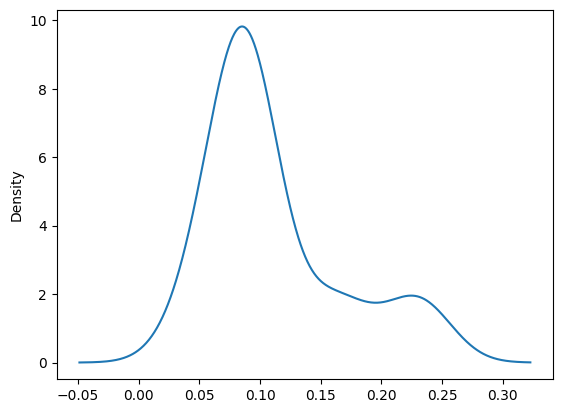

In [8]:
def render_simple_density(colname):
    # Show default density plot
    df_agg[colname].plot.kde()

interactive_single_var_dropdown(options = cols_fairness + cols_performance, render_function=render_simple_density)

In [9]:
import plotly.express as px

def render_plotly_density(colname):
    fig = px.histogram(
        df_agg,
        x=colname,
        marginal="rug",
        hover_data=cols_settings
    )
    fig.show()

interactive_single_var_dropdown(options = cols_fairness + cols_performance, render_function=render_plotly_density)

Dropdown(description='Column:', options=('fair_main_equalized_odds_difference', 'fair_main_equalized_odds_rati…

In [10]:
px.scatter(
    df_agg,
    x="perf_ovrl_accuracy",
    y=main_fairness_metric,
    marginal_x="violin",
    marginal_y= "violin",
    hover_data=cols_settings,
    title="Accuracy x Fairness"
)

## Exploratory Analysis of Fairness based on Settings

In [11]:
import plotly.express as px

def fairness_violin(column_to_compare):
    fig = px.violin(
        df_agg,
        x = column_to_compare,
        y = main_fairness_metric,
        color = column_to_compare,
        points = "all",
        hover_data = cols_settings
    )
    # fig.update_traces(pointpos=0)
    display(fig)

interactive_single_var_dropdown(options = cols_settings, render_function=fairness_violin)

Dropdown(description='Column:', options=('sett_cutoff', 'sett_eval_fairness_grouping', 'sett_exclude_features'…